In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import timm
import os
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from skimage import io
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import random

## Cuda


In [2]:
#Controllo che torch sia installato con CUDA abilitato
def check_cuda():
    print(torch.version.cuda)
    cuda_is_ok = torch.cuda.is_available()
    print(f"CUDA Enabled: {cuda_is_ok}")

In [3]:
print(torch.version.cuda)

11.7


## Model parameters


In [4]:
model_weights = True

In [5]:
#Directory per i file di train
DATA_DIR = ''

#Grandezza del Batch (iperparametro)
BATCH_SIZE = 32

#Learning Rate (Iperparametro)
LR = 0.001

#Numero di epoche (Iperparametro)
EPOCHS = 80

DEVICE = 'cuda'

## Dataloader and dataset creation

In [6]:
# Carica il file csv
df_real = pd.read_csv("real_image_dataset_coco.csv")

df_fake = pd.read_csv("fake_image_dataset_biggan.csv")

train_df_real, valid_df_real = train_test_split(df_real, test_size = 0.20, random_state = 42)
train_df_fake, valid_df_fake = train_test_split(df_fake, test_size = 0.20, random_state = 42)

test_df_real = train_df_real.sample(500)
test_df_fake = train_df_fake.sample(500)

train_df_real = train_df_real.drop(test_df_real.index)
train_df_fake = train_df_fake.drop(test_df_fake.index)

train_df = pd.concat([train_df_real, train_df_fake])
valid_df = pd.concat([valid_df_real, valid_df_fake])

test_df = pd.concat([test_df_fake,test_df_real])

# shuffle
train_df= train_df.sample(frac= 1)
valid_df= valid_df.sample(frac= 1)

# Unisci tutti i dataframe in un unico dataframe finale per il train set
final_df = pd.concat([train_df, valid_df])

# Salva il dataframe finale di trian in un file CSV
#final_df.to_csv("spectrum_train_dataset.csv", index=False)
df = pd.read_csv("spectrum_train_dataset.csv")

# Crea una lista combinata con 500 immagini false seguite da 500 immagini reali
combined_images = test_df["Anchor"]

# Crea il dataframe del test set con una sola colonna
#test_df = pd.DataFrame(combined_images, columns=[''])

# Salva il dataframe del test set in un file CSV
#test_df.to_csv("test_set.csv", index=False, header=False)

print('Size of train set:', len(train_df))
print('Size of valid set:', len(valid_df))
print('Size of test set:', len(test_df))

Size of train set: 15000
Size of valid set: 4000
Size of test set: 1000


In [7]:
# Carico le immagini del file CSV che ho fornito, per settarle in modo corretto e darle in input alla rete neurale
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor, as_gray= True)
    P_img = io.imread(DATA_DIR + row.Positive, as_gray= True)
    N_img = io.imread(DATA_DIR + row.Negative, as_gray= True)

    
    # Aggiungi dimensione per il batch
    A_img = np.expand_dims(A_img, 0)
    P_img = np.expand_dims(P_img, 0)
    N_img = np.expand_dims(N_img, 0)

    A_img = torch.from_numpy(A_img)/ 255.0
    P_img = torch.from_numpy(P_img)/ 255.0
    N_img = torch.from_numpy(N_img)/ 255.0
      
    #A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    #P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    #N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [8]:
data = APN_Dataset(train_df)
item1, item2, item3 = data.__getitem__(0)
print(item1.shape)

torch.Size([1, 200, 200])


Qui di seguito mi stampo il numero che compone l'insieme di dati di train, test e validation

In [9]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
testset = APN_Dataset(test_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")
print(f"Size of validset: {len(testset)}")

Size of trainset: 15000
Size of validset: 4000
Size of validset: 1000


Carichiamo i dati di train e validation nella batch

In [10]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)
testloader = DataLoader(testset, batch_size = 1)

In [11]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")
print(f"No. of batches in testloader : {len(testloader)}")

No. of batches in trainloader : 469
No. of batches in validloader : 125
No. of batches in testloader : 1000


Questa funzione definisce un modello di rete neurale chiamato APN_Model, che carica un'architettura di rete preaddestrata e sostituisce il classificatore finale con un nuovo classificatore personalizzato.

## Model definition

In [12]:
#Carico il modello di rete neurale
class APN_Model(nn.Module):

    #Viene definita la size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    #QUI CAIRCATE IL MODELLO, IN QUESTO CASO EFFICIENTNET VERSIONE B0 (LA PIù LEGGERA DELLA FAMIGLIA)
    self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained = False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [26]:
#QUI FATE UNA PICCOLA MODIFICA ALLA RETE PER FARLE AVERE IN INPUT IMMAGINI IN SCALA DI GRIGIO DELLO SPETTRO DI FOURIER
model = APN_Model()
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False);

if model_weights == True :
    model.load_state_dict(torch.load('trained_model_on_20000.pt'))

model.to(DEVICE);

TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.

## Evaluation functions

In [15]:
#FUNZIONE DI TEST
def test_fn(model, dataloader, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  with torch.no_grad():  
    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
      
        loss = criterion(A_embs, P_embs, N_embs)
      
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
#FUNZIONE DI TRAINING
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [17]:
#FUNZIONE DI EVALUATION
def eval_fn(model, dataloader, criterion):
  model.eval() #OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.model = None

    def early_stop(self, validation_loss, model_updated):
        print(validation_loss)
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            print("New min - model updated")
            self.model = model_updated
            torch.save(self.model, 'trained_model_on_20000.pt')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            print(f"Counter updated {self.min_validation_loss + self.min_delta}")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def get_model(self):
        return self.model

## Training parameters

In [19]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [20]:
early_stopper = EarlyStopper(patience=5, min_delta=0.08)


## Training

In [21]:
#Training
if model_weights == False :
    best_valid_loss = np.Inf
    training_loss = []
    validation_loss = []
    for i in range(EPOCHS):
      train_loss = train_fn(model, trainloader, optimizer, criterion)
      valid_loss = eval_fn(model, validloader, criterion)
      training_loss.append(train_loss)
      validation_loss.append(valid_loss)
      if early_stopper.early_stop(valid_loss, model.state_dict()):             
          break
          
      print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

torch.save(early_stopper.get_model(), 'trained_model_on_20000.pt')


In [22]:
#Salvataggio plottato dei dati
if(model_weights == False):    
    fig, axes = plt.subplots(2, 1, sharex= True, figsize=(10, 6))
    axes[0].plot(training_loss)
    axes[0].set_title('Training Loss - Triplet margin loss')
    axes[1].plot(validation_loss)
    axes[1].set_title('Validation Loss - Triplet margin loss')
    plt.savefig('training_data_20000(biggan)-80-epochs.png')
    plt.show()

## Databse training embedded

In [23]:
#QUESTA E' LA FUNZIONE PER GENERARE I VETTORI DI ENCODING
# concatenating images name and relative encodings
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(dirFolder + i)
      A = np.expand_dims(A, 0)
      A = torch.from_numpy(A.astype(np.int32)) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [24]:
#QUI IL DATABASE COME CSV IN MODO TALE DA NON DOVER FARE QUESTA OPERAZIONE OGNI VOLTA
#OVVIAMENTE, SE DEVO FARE UN NUOVO TRAINING DEVO ANCHE RICREARE GLI ENCODINGS
if(model_weights == False):
    df_enc.to_csv('database_biggan.csv', index = False)
    df_enc.head()
df_enc = pd.read_csv('database_biggan.csv')

In [25]:
#QUI CREO IL DATABASE DI FEATURE VECTORS DEL TRAINING SET
df_enc = get_encoding_csv(model, df['Anchor'], DATA_DIR)

  0%|                                                                                        | 0/19000 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

## Distances, Get image embeddings and searching in databse

In [25]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    #dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    return dist

In [26]:
# return the embedding of the image
def getImageEmbeddings(img, model):

    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img) / 255
    model.eval();

    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

## Adding 5 Latent Diffusion, 5 Taming Transformer

In [27]:
(df_enc.describe())

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,...,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000
mean,-0.884197,1.174867,-0.162072,2.372958,-1.097224,0.590331,1.146033,-0.786790,0.916750,-0.253910,...,-0.918830,1.055716,0.451887,-2.334898,3.705020,0.756638,1.649241,-5.629300,-0.617569,-3.069335
std,0.057336,0.035830,0.010621,0.080495,0.078799,0.015979,0.059848,0.018527,0.061650,0.036521,...,0.030783,0.062237,0.038816,0.084514,0.088328,0.023599,0.070680,0.151020,0.035683,0.086671
min,-1.123815,1.114091,-0.194880,2.279617,-1.448037,0.451607,1.073621,-0.833690,0.844957,-0.327505,...,-1.010936,0.982677,0.407981,-2.610969,3.549509,0.565516,1.565335,-6.059702,-0.747482,-3.309109
25%,-0.939234,1.138586,-0.170593,2.291092,-1.173884,0.579485,1.085283,-0.801466,0.854605,-0.288082,...,-0.949897,0.992711,0.412899,-2.419810,3.616133,0.740606,1.577522,-5.781886,-0.653540,-3.157063
50%,-0.884307,1.191901,-0.156982,2.389071,-1.100324,0.590647,1.153252,-0.789315,0.916656,-0.253389,...,-0.921140,1.057342,0.450815,-2.348827,3.728864,0.759026,1.654176,-5.659119,-0.618729,-3.087799
75%,-0.826499,1.209305,-0.155484,2.454265,-1.017673,0.603658,1.204084,-0.773836,0.978394,-0.224171,...,-0.887740,1.116209,0.491091,-2.249344,3.792639,0.775767,1.719265,-5.476255,-0.581426,-2.981225
max,-0.807100,1.269023,-0.121735,2.613164,-1.005671,0.629433,1.389890,-0.653319,1.178585,-0.025364,...,-0.881922,1.316527,0.607452,-2.237084,3.963905,0.813514,1.908085,-5.372425,-0.574358,-2.946775


In [28]:
# Funzione per ottenere i percorsi delle immagini
def get_image_paths(folder):
    image_paths = []
    for root, dirs, files in os.walk(folder):
        for filename in files:
            if filename.endswith(".jpg"):
                image_paths.append(os.path.relpath(os.path.join(root, filename)))
    return image_paths

In [29]:
current_dir = os.getcwd()
fake_image_folder_latent = os.path.join(current_dir, "dataset", "latent_diffusion", "latentdiff-t2i_spectrum")
fake_image_folder_taming = os.path.join(current_dir, "dataset", "taming_transformer", "tt-ffhq_spectrum")

fake_image_paths_latent = get_image_paths(fake_image_folder_latent)
fake_image_paths_taming = get_image_paths(fake_image_folder_taming)

print("Numero di immagini latenti:", len(fake_image_paths_latent))
print("Numero di immagini taming:", len(fake_image_paths_taming))

# Selezionare un numero casuale di immagini
num_random_elements = 1000
taming_random = random.sample(fake_image_paths_taming, num_random_elements)
latent_random = random.sample(fake_image_paths_latent, num_random_elements)

# Ottenere gli embedding delle immagini selezionate
embeddings_new_taming_latent_imgs = []
image_paths = []

for i in range(num_random_elements):
    taming_random_img = io.imread(taming_random[i])
    latent_random_img = io.imread(latent_random[i])
    taming_random_img_embed = getImageEmbeddings(taming_random_img, model)[0, :]
    latent_random_img_embed = getImageEmbeddings(latent_random_img, model)[0, :]
    embeddings_new_taming_latent_imgs.append(taming_random_img_embed)
    embeddings_new_taming_latent_imgs.append(latent_random_img_embed)
    image_paths.append(taming_random[i])
    image_paths.append(latent_random[i])

Numero di immagini latenti: 10000
Numero di immagini taming: 50000


In [30]:
# Creare un DataFrame con gli embedding e i percorsi delle immagini
df_latent_taming_new = pd.DataFrame(embeddings_new_taming_latent_imgs)
df_latent_taming_new['Anchor'] = image_paths

# Verifica del DataFrame creato
print("Nuovo DataFrame con embedding e percorsi delle immagini:")
print(df_latent_taming_new.head())

# Concatenare con il DataFrame esistente
df_enc_plus_latent_taming = pd.concat([df_enc, df_latent_taming_new], ignore_index=True)

# Salviamo il DataFrame risultante in un CSV
df_enc_plus_latent_taming.to_csv('new_database_with(1000-latent_1000-taming).csv', index=False)

saved_df = pd.read_csv('new_database_with(1000-latent_1000-taming).csv')

Nuovo DataFrame con embedding e percorsi delle immagini:
          0         1         2         3         4         5         6  \
0 -0.828495  1.136314 -0.156000  2.287863 -1.016009  0.601603  1.084617   
1 -0.820487  1.138574 -0.154578  2.287149 -1.014650  0.605509  1.080806   
2 -0.836749  1.132694 -0.153212  2.284738 -1.020524  0.590486  1.089877   
3 -0.923515  1.216658 -0.161515  2.448773 -1.159096  0.593547  1.194098   
4 -0.829189  1.135808 -0.155092  2.286202 -1.014297  0.600229  1.084841   

          7         8         9  ...       503       504       505       506  \
0 -0.796112  0.852873 -0.284771  ...  0.992908  0.411358 -2.246380  3.608290   
1 -0.804408  0.852071 -0.292992  ...  0.988550  0.412253 -2.243452  3.615056   
2 -0.785109  0.856669 -0.268354  ...  0.997952  0.411644 -2.245922  3.587392   
3 -0.799544  0.961848 -0.243668  ...  1.103216  0.480922 -2.409050  3.808773   
4 -0.794835  0.851558 -0.281873  ...  0.992757  0.410275 -2.245044  3.602534   

        507

In [31]:
# return the closest image in the database given an img_enc
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database['Anchor']

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)
    
    closest_idx = np.argsort(distance)

    return database['Anchor'][closest_idx[0]]

# Defining test list

In [48]:
test = "test_set_taming_transformer.csv"
test_latent = pd.read_csv(test, header = None)

## Testing

In [49]:
database = df_enc_plus_latent_taming
(database.describe())
y_true = ['fake'] * 500 + ['real'] * 500
y_pred = []

In [50]:
def test_images(test_df, start_index, end_index, database, model):
    for index, row in tqdm(test_df.iloc[start_index:end_index].iterrows(), total=end_index-start_index):
        img_name = row[0] # Accesso diretto alla prima (e unica) colonna

        # Verifica se il nome del file è valido
        if pd.isnull(img_name) or not os.path.isfile(img_name):
            print(f"Invalid image file path at index {index}: {img_name}")
            y_pred.append("error")
            continue
        
        # Leggi e processa l'immagine
        img = io.imread(img_name)

        # Ottieni gli embeddings dell'immagine
        img_enc = getImageEmbeddings(img, model)

        # Cerca nel database
        closestLabel = searchInDatabase(img_enc, database)
       
        # Aggiungi la predizione alla lista
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

In [51]:
test_images(test_latent, 0, 1000, database, model)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:55<00:00,  3.38it/s]


In [52]:
#Creo i vettori di ground truth
y_true = np.array(['fake'] * 500)
print(y_true.shape)

temp = np.array(['real'] * 500)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

#Calcolo la matrice di confusione
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])

(500,)
(500,)
(1000,)


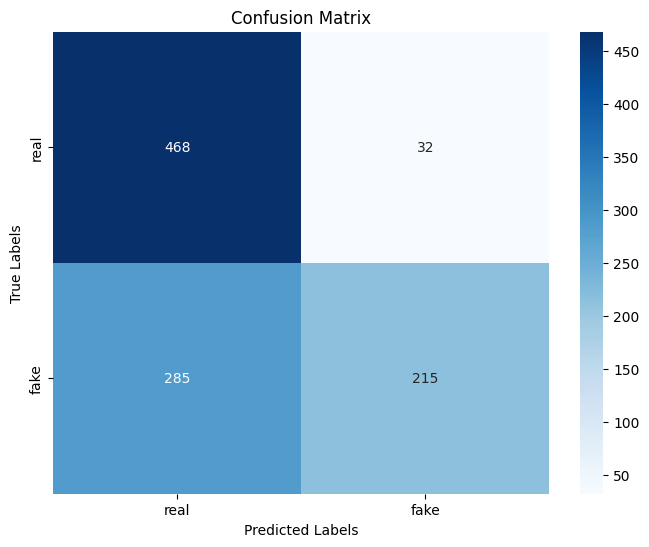

In [53]:
#Estraggo dalla matrice di confusione i True Negative, False Positive, False Negative, True Positive
TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=["real", "fake"]).ravel()

# Plotto la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
# Salvo l'immagine
plt.savefig('confusion_matrix_1000(taming_transformer-coco)_new_database(2000imgs).png')
plt.show()

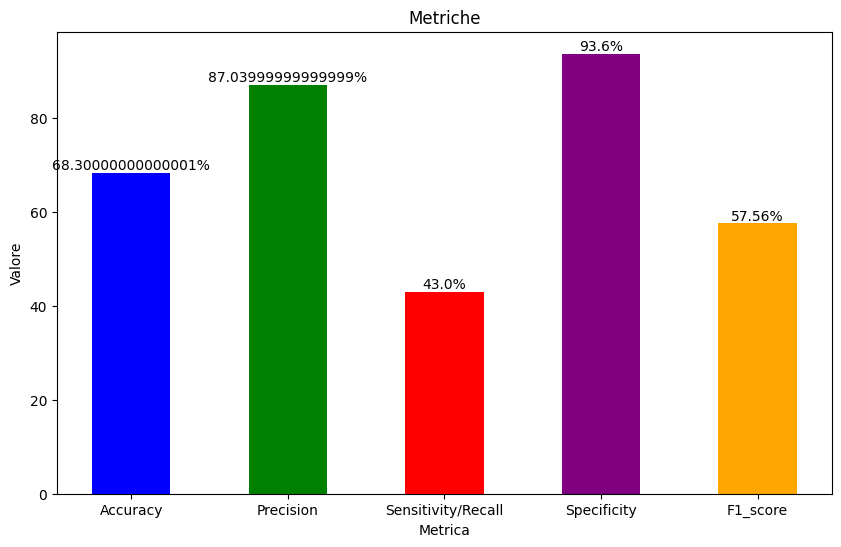

In [54]:
#Calcolo alcune metriche per vedere come si comporta
accuracy = round((TP + TN) /(TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
sensitivy_recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
F1_score = round((2* precision * sensitivy_recall) / (precision + sensitivy_recall), 2)

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Sensitivity/Recall": sensitivy_recall,
    "Specificity": specificity,
    "F1_score": F1_score
}

# Nomi delle metriche
labels = list(metrics.keys())

# Valori delle metriche
values = list(metrics.values())

# Creazione dell'istogramma
plt.figure(figsize=(10,6))
plt.bar(labels, values, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)

# Aggiunta delle etichette
for i in range(len(labels)):
    plt.text(i, values[i], f'{values[i]}%', ha = 'center', va = 'bottom')

# Titoli e etichette degli assi
plt.title('Metriche')
plt.xlabel('Metrica')
plt.ylabel('Valore')

plt.savefig('Metrics_with_taming_transformer-coco_new_database(2000imgs).png')

# Mostra l'istogramma
plt.show()

In [55]:
print({"Accuracy":accuracy,"Precision":precision,"Sensitivity_recall":sensitivy_recall, "Specificity": specificity, "F1_score":F1_score})

{'Accuracy': 68.30000000000001, 'Precision': 87.03999999999999, 'Sensitivity_recall': 43.0, 'Specificity': 93.6, 'F1_score': 57.56}


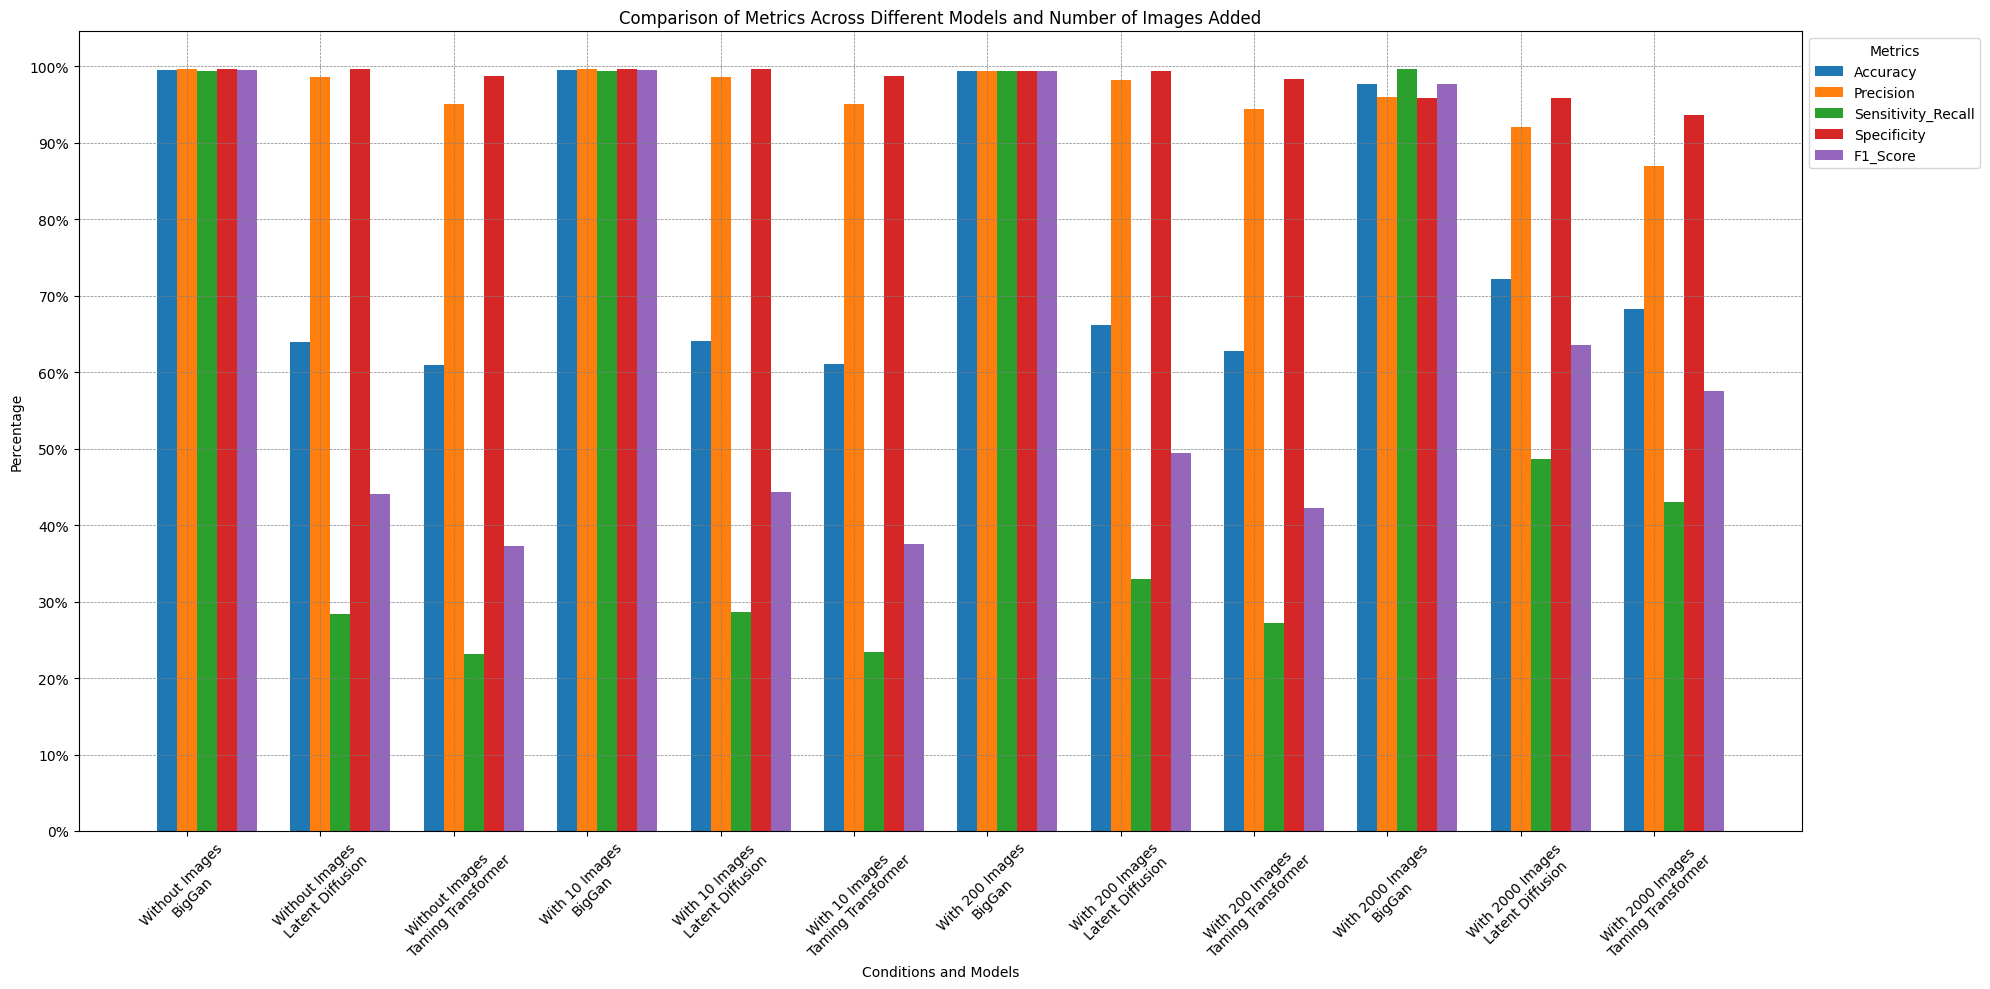

In [19]:
# Data structured with models, metrics, and counts
data = {
    'condition': (['Without Images']*15 + ['With 10 Images']*15 + 
                  ['With 200 Images']*15 + ['With 2000 Images']*15),
    'model': (['BigGan']*5 + ['Latent Diffusion']*5 + ['Taming Transformer']*5) * 4,
    'metric': ['Accuracy', 'Precision', 'Sensitivity_Recall', 'Specificity', 'F1_Score'] * 12,
    'count': [
        99.5, 99.6, 99.4, 99.6, 99.5, 64.0, 98.61, 28.4, 99.6, 44.1, 61.0, 95.08, 23.20, 98.8, 37.3,  # Without Images
        99.5, 99.6, 99.4, 99.6, 99.5, 64.1, 98.619, 28.59, 99.6, 44.34, 61.1, 95.12, 23.40, 98.8, 37.56, # With 10 Images
        99.4, 99.4, 99.4, 99.4, 99.4, 66.2, 98.21, 33.0, 99.4, 49.4, 62.8, 94.44, 27.20, 98.4, 42.24,  # With 200 Images
        97.7, 95.95, 99.6, 95.8, 97.74, 72.2, 92.05, 48.6, 95.8, 63.61, 68.30, 87.03, 43.0, 93.6, 57.56  # With 2000 Images
    ]
}

df = pd.DataFrame(data)

# Convert 'count' to percentages
df['count'] = df['count'] / 100

# Prepare the plot
plt.figure(figsize=(20, 10))

# Generate the unique x positions for each condition and metric
conditions = df['condition'].unique()
metrics = df['metric'].unique()
models = df['model'].unique()
x = np.arange(len(conditions) * len(models))  # the label locations
width = 0.15  # the width of the bars

# Plotting
for i, metric in enumerate(metrics):
    counts = []
    for condition in conditions:
        for model in models:
            count = df[(df['condition'] == condition) & 
                       (df['metric'] == metric) & 
                       (df['model'] == model)]['count'].values[0]
            counts.append(count)
    plt.bar(x + i*width, counts, width, label=metric)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Percentage')
plt.xlabel('Conditions and Models')
plt.title('Comparison of Metrics Across Different Models and Number of Images Added')
plt.xticks(x + width, [f'{condition}\n{model}' for condition in conditions for model in models], rotation=45)
plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
plt.legend(loc='upper left', bbox_to_anchor=(1,1), title="Metrics")

plt.tight_layout()
plt.savefig('All_Metrics_showed.png')
plt.show()